# What would be the ideal way to do this?

1. Define points $x_0,\dots,x_{n-1}$ (arbitrary) and pick some $\varepsilon$
2. Define the $\varepsilon$ graph. That is the graph where $i-j$ connect if $D[i,j] \leq \varepsilon$
3. Define the VR complex at $\varepsilon$. Every complete subgraph becomes a simplex. This is where we wonder if enumerating all simplices creates duplicates

Idea: Only generate simplices with increasing vertex order.
$$N^+(i) = \{\, j>i : D[i,j]\leq \varepsilon \,\}$$
I.e. neighbors that come after me.

4. Now we have a simplex $\sigma = [i_0<i_1<\dots<i_k]$. We want to add a new vertex $n$ to make the simplex larger. For $\sigma \cup \{n\}$ to be a simplex, $n$ must connect to every vertex in $\sigma$ in the $\varepsilon$ graph. 

$$n \in N^+(i_0)\cap N^+(i_1)\cap \cdots \cap N^+(i_k)$$

This is why we should maintain a candidate set $C(\sigma) = N^+(i_0)\cap N^+(i_1)\cap \cdots \cap N^+(i_k)$. Now we start at vertex $i$ and find $C([i]) = N^+(i)$. If we extend by adding n, the new candidates become $C(\sigma \cup \{n\}) = C(\sigma)\cap N^+(n)$.

This guarantees that only vertices that connect to all simplex vertices are considered and they respect ordering.

5. If we were to compute all edges, then all triangles, ..., we would store too many simplices. We want to build one simplex at a time, emit its contribution as soon as possible, then backtrack.

# What does Dlotko do compared to this?

1. We already define points in an ascending arbitrary manner with this.
```python
def pairwise_dist(X: np.ndarray) -> np.ndarray: #input is a shape X with n points and d dim
    diff = X[:, None, :] - X[None, :, :] #diff is every pairwise distance vector
    return np.linalg.norm(diff, axis=2)

def subseq_neighbors(D: np.ndarray, i: int, epsilon: float) -> list[int]:
    n = D.shape[0] #precomputed distance matrix D (n is number of points)
    js = np.where((D[i] <= epsilon) & (np.arange(n) > i))[0]
    return js.tolist()
```
subseq_neighbors returns the neighbor set of a vertex with only indices larger than itself ($N^+(i) = \{\, j > i \mid D[i,j] \leq \varepsilon \,\}$). This is how we enforce ordering and avoid duplicate simplices. Let's analyze the line `js = np.where((D[i] <= epsilon) & (np.arange(n) > i))[0]`. `D[i] <= epsilon` is taking the ith row of the distance matrix produces a boolean array containing True is point j is withing $\varepsilon$ of i. `np.arange(n) > 1` creates $[0,1, \dots, n-1]$ and produces a boolean list of True if the indice in greater than i. Now we take the and of these two state ments so we have a boolean list that says True if the point is within $\varepsilon$ distance and its index is $> i$. `np.where` returns the indices where the condition is True, so js is an array of valid neighbors of vertex $i$. 

pairwise_dist takes in a shape $X$ and outputs its symmetric distance matrix $D[i,j] = \|X[i] - X[j]\|$. We can have some issues here with large VR. If $n=10,000$, then $D$ contains 100,000,000 entries. Potentially think about avoiding storing the full distance matrix. 

2. Looking at the Algorithms

Abstractly what we want to do is:

```python
for each i:
    expand([i], 0, N+(i))
```

We currently have:

```python
for i in range(n):
    simplices = [[i]] #this is a list of a list just like a simplex is a set of a set (this is initializing our simplex)
    filtrations = [0]
    common_subseq_neighs = subseq_neighbors(D, i, epsilon) #this is C = N+(i)
```
These two are identical.


Now we want to `emit(fsigma, (-1)^dim)` and we have:

```python
for sigma, f_sigma in zip(simplices, filtrations):
    dim_sigma = len(sigma) - 1
    sign = 1 if (dim_sigma % 2 == 0) else -1 #this is for EC assigns its sign in the alternating sum
    C.append((f_sigma, sign)) #stores a pair (filtration value, +-1)
```

Now we wish to grow the simplex. 

Ideally:
```python
for n in C:
    f_new = max(fsigma, max_{v in sigma} D[v,n])
    C_new = C intersect N+(n)
```
We have:
```python
for sigma, f_sigma, commonN in zip(simplices, filtrations, common_subseq_neighs):
    for n in commonN:
        sigma2 = sigma + [n]
```
This corresponds to item number 4 on the top block.

Now we need to update the filtration for this new simplex ($\sigma \cap \{n\}$). Ideally in pseudo code this is `f_new = max(fsigma, longest_edge)` We have:

```python
longest_edge = 0.0
for v in sigma:
    d = D[v,n]
    if d > longest_edge:
        longest_edge = d
new_f = max(f_sigma, longest_edge)
``` 
This is the same mathematically as the pseudocode.

After this we need to update the candidate set `C_new = C intersect N+(n)`. We have:

```python
neigh_n = subseq_neighbors(D, n, epsilon)
intersection = sorted(set(commonN).intersection(neigh_N))
```
which is the same mathematically as well.

Now we hit a difference!

Ideally we build one simplex chain as deep as possible then backtrack like:
```python
expand(i):
    expand(i,j):
        expand(i,j,k):
            expand(i,j,k,l):
                ...
```
This stores memory in terms of O(max simplex dim) not O(simplex number)

We currently have
```python
while simplices not empty:
    record all simplices at this dimension
    simplices = inc_dim(...)
```

This iterates all vertices, then edges starting at i, then triangles at i, ... We have a memory risk in the logic here.

Another place we have a memory risk is that we recompute `neigh_n = subseq_neighbors(D, n ,epsilon)` every time we extend the simplex, which is redundant. 


# Let's try to Optimize this

In [90]:
import numpy as np

def pairwise_dist(X: np.ndarray) -> np.ndarray:
    diff = X[:, None, :] - X[None, :, :]
    return np.linalg.norm(diff, axis = 2)
#this is the same as before inputs shape X and outputs symmetric distance matrix D

def Nplus(D: np.ndarray, epsilon: float) -> list[np.ndarray]:
    #precompute Nplus[i] = sorted array of neighbors j > i with D[i,j] <= epsilon
    n = D.shape[0] #number of vertices
    N = []
    for i in range(n):
        js = np.where(D[i, i + 1:] <= epsilon)[0] + (i + 1)
        N.append(js.astype(np.int32))
    return N #prevents double counting and returns the N+ matrix for all vertices

def intersect_sorted(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    #intersection of two sorted integer arrays with numpys intersect1d
    if a.size == 0 or b.size == 0:
        return np.empty(0, dtype = np.int32)
    return np.intersect1d(a, b, assume_unique=False)
    # this is how we enforce that future vertices must neighbor all current simplex vertices


def local_contributions_vr( #enumerating all simplices in the epsilon graph up to some max_dim
        X: np.ndarray,
        epsilon: float,
        max_dim: int | None = None,
        ) -> list[tuple[float, int]]:
    """
    Using clean depth-first search complete subgraph enumeration in the epsilon graph with ordered neighbor sets.
    Emits (filtration_value, (-1)^dim) for each simplex found to save memory.
    outputs C which is a list of events at filtration value f add 1 or subtract 1
    """
    X = np.asarray(X, dtype = float)
    n = X.shape[0]
    D = pairwise_dist(X)
    N = Nplus(D, epsilon)

    C: list[tuple[float, int]] = [] # candidate set is a set of float,int tuples with (filtration_val, sign)
    
    def expand(simplex: list[int], candidates: np.ndarray, f_simplex: float):
        #simplex is a list of vertex indices in sigma. Candidates is the allowed vertices to add next (the intersection set).
        #f_simplex is the current filtration value for sigma (max edge in sigma so far). 

        #emit contribution of the current simplex for memory
        dim = len(simplex) - 1
        sign = 1 if (dim % 2 == 0) else -1
        C.append((f_simplex, sign))

        #dimension cap (don't expand further than max_dim)
        if max_dim is not None and dim >= max_dim:
            return
        
        #now try expanding by each candidate vertex v
        for v in candidates:
            v = int(v)
            #update filtration with max of current filtration and longest edge to v
            longest_edge = 0.0
            for u in simplex:
                d = D[u, v]
                if d > longest_edge:
                    longest_edge = d
            f_new = max(f_simplex, longest_edge)
            # computes max(f_sigma, maxD[u,v] for u in sigma)

            #update candidate set (C intersect N+[v] = C(sigma union {v}))
            candidates_new = intersect_sorted(candidates, N[v])

            simplex.append(v) #add v
            expand(simplex, candidates_new, f_new)
            simplex.pop()
    
    #start from each vertex i as the smallest vertex index
    for i in range(n):
        expand([i], N[i], 0.0)
    
    C.sort(key = lambda t: t[0]) #sort by filtration value to to cumulatibe sums in order
    return C


# What now?

Now we have $C = \{(f(\sigma),\, (-1)^{\dim \sigma}) : \sigma \text{ is a simplex}\}$, our total candidate matrix containing tuples of (filtration value, sign) for all vertices. If we want to compute the EC at a value of epsilon we need to compute $\chi(r) = \sum_{\sigma \in VR_r}^{} (-1)^{\dim \sigma}$ with our VR complex defined as $VR_r = \{ \sigma : f(\sigma) \le r \}$. Which is the same as $\chi(r) = \sum_{\sigma:\, f(\sigma)\le r} (-1)^{\dim \sigma}$. Now observe that we currently have $C = \{(f(\sigma), s_\sigma)\}$ with $s_\sigma = (-1)^{dim(\sigma)}$. So computing the EC at radius r is $\chi(r) = \sum_{(f,s)\in C,\ f\le r}s$. Let's define that in a function in python below. 

In [ ]:
def EC_from_C(C: list[tuple[float, int]]):
    # Edge case: no events
    if not C:
        return lambda r: 0

    # Split C into two arrays: filtration values and signs
    filtration_values = np.array([f for (f, _) in C], dtype=float)
    signs = np.array([s for (_, s) in C], dtype=int)

    # Prefix sums: prefix_sums[k] = sum of signs from 0 through k
    prefix_sums = np.cumsum(signs)

    def chi(r: float) -> int:
        """
        Euler characteristic at radius r:
        include all events with filtration_value <= r.
        """
        # number of events with f <= r
        k = np.searchsorted(filtration_values, r, side="right")

        # sum of first k signs
        if k == 0:
            return 0
        return int(prefix_sums[k - 1])

    return chi
n = 100
X = np.random.uniform(0,1, size = (n,1))
C = local_contributions_vr(X, epsilon=1.0, max_dim=2) 
chi = EC_from_C(C)

print(chi(0.2))
print(chi(0.7))

16940
135193


# Thoughts
This works fine. Takes a good amount of time if we only want EC at certain epsilon values and not the whole ECC.

# Can we save time by calculating at discrete values of $\varepsilon$? Yes.

1.	If we only need $\chi(r)$ at a single radius, we can compute it during DFS without storing/sorting events: maintain a running total and only add a simplex’s sign when $f(\sigma)\le r$. Since filtration values are nondecreasing under expansion, we can prune any branch once $f(\sigma)>r$.
2.	For each point cloud $X$, compute the distance matrix $D$ once $(O(n^2))$ and reuse it across all radii.
3.	The $\varepsilon$-graph is nested: $G_{\varepsilon_1}\subseteq G_{\varepsilon_2}$ for $\varepsilon_1<\varepsilon_2$. We can exploit this by building neighbor lists/edges in a monotone way (e.g., sorting edges by distance), rather than recomputing from scratch for each \varepsilon.



In [237]:
def chi_one_r(
    X: np.ndarray,
    r: float,
    max_dim: int | None = None,
) -> int:
    """
    Compute chi(r) directly (no event list C).
    Enumerates simplices in the r-neighbor graph and accumulates (-1)^dim.
    """
    X = np.asarray(X, dtype=float)
    n = X.shape[0]

    D = pairwise_dist(X)
    N = Nplus(D, r)

    total = 0

    def expand(simplex: list[int], candidates: np.ndarray):
        nonlocal total

        dim = len(simplex) - 1
        sign = 1 if (dim % 2 == 0) else -1
        total += sign

        if max_dim is not None and dim >= max_dim:
            return

        for v in candidates:
            v = int(v)
            candidates_new = intersect_sorted(candidates, N[v])
            simplex.append(v)
            expand(simplex, candidates_new)
            simplex.pop()

    for i in range(n):
        expand([i], N[i])

    return total

n = 100
X = np.random.uniform(0, 1, size=(n, 1))

print(chi_one_r(X, r=0.2, max_dim=2))
print(chi_one_r(X, r=0.7, max_dim=2))

14664
114075


# Let's now try to run this simulation style

In [238]:
def run_ec_simulation(
    n: int,
    epsilons: list[float],
    trials: int,
    max_dim: int | None = None,
    seed: int | None = None,
):
    """
    Run multiple trials of uniform sampling on [0,1] and compute EC at each epsilon value.

    Parameters
    n : number of sampled points per trial
    epsilons : list of epsilon (r) values
    trials : number of simulation runs
    max_dim : maximum simplex dimension (None = no cap)
    seed : optional random seed

    Returns
    results : dict mapping epsilon -> numpy array of EC values
    """
    rng = np.random.default_rng(seed)

    results = {eps: [] for eps in epsilons}

    for _ in range(trials):

        # Sample n points uniformly in [0,1]
        X = rng.uniform(0.0, 1.0, size=(n, 1))

        # Compute distance matrix once per trial
        D = pairwise_dist(X)

        # Compute EC at each epsilon
        for eps in epsilons:
            chi = chi_one_r(D, eps, max_dim=max_dim)
            results[eps].append(chi)

    # Convert lists to numpy arrays
    for eps in epsilons:
        results[eps] = np.array(results[eps], dtype=int)

    return results

{0.15: array([39, 27, 63, 70, 69, 40, 57, 45, 64, 80, 58, 52, 58, 46, 42, 48, 57,
       44, 66, 74, 53, 80, 72, 57, 49, 47, 64, 67, 50, 56]), 0.25: array([ 97, 100, 211, 143, 188,  99, 166, 124, 159, 170, 200, 116, 130,
       121,  95, 122, 190, 113, 178, 171, 147, 234, 131, 159, 114, 144,
       155, 149, 130, 159]), 0.35: array([230, 255, 425, 338, 459, 270, 329, 275, 389, 416, 448, 283, 323,
       273, 231, 277, 351, 287, 423, 405, 375, 399, 322, 355, 283, 348,
       325, 345, 314, 462])}


In [247]:
results = run_ec_simulation(
    n=100,
    epsilons=[0.15, 0.3, 0.6],
    trials=50,
    max_dim=25,
    seed=0
)

def summarize_results(results: dict[float, np.ndarray]):
    summary = {}

    for eps, values in results.items():
        summary[eps] = {
            "mean": float(np.mean(values)),
            "std": float(np.std(values, ddof=1)),   # sample std
            "min": int(np.min(values)),
            "max": int(np.max(values)),
        }

    return summary


summary = summarize_results(results)

for eps, stats in summary.items():
    print(f"\nEpsilon = {eps}")
    for k, v in stats.items():
        print(f"  {k}: {v}")


Epsilon = 0.15
  mean: 22.46
  std: 2.786336926753072
  min: 17
  max: 29

Epsilon = 0.3
  mean: 5.62
  std: 1.6399352899130017
  min: 2
  max: 9

Epsilon = 0.6
  mean: 1.22
  std: 0.5066899385990914
  min: 1
  max: 3


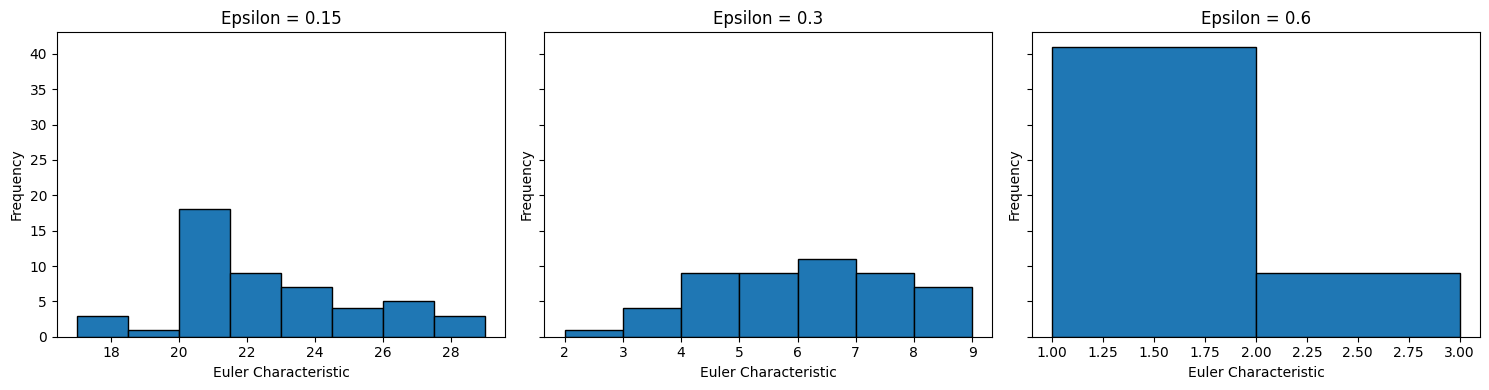

In [248]:
import matplotlib.pyplot as plt

def plot_ec_histograms(results: dict[float, np.ndarray]):
    num_eps = len(results)
    fig, axes = plt.subplots(1, num_eps, figsize=(5*num_eps, 4), sharey=True)

    if num_eps == 1:
        axes = [axes]

    for ax, (eps, values) in zip(axes, results.items()):
        ax.hist(values, bins="auto", edgecolor="black")
        ax.set_title(f"Epsilon = {eps}")
        ax.set_xlabel("Euler Characteristic")
        ax.set_ylabel("Frequency")

    plt.tight_layout()
    plt.show()


plot_ec_histograms(results)